In [1]:
import numpy as np
import xarray as xr
import healpy as hp

import intake
from easygems import healpix as egh

import matplotlib.pyplot as plt
import cmocean as cm

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import ShapelyFeature

import pandas as pd
import geopandas as gpd
import osmnx as ox
import rioxarray
from rasterio import features

from shapely.geometry import Point, Polygon, MultiPolygon

from easygems.healpix import attach_coords

In [2]:
zoom = '10'
direc = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z" + zoom +".zarr" # UM PT1H is hourly data
# direc = "/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z10_atm.zarr" #ICON PT1H is hourly data
ds = xr.open_zarr(direc)
ds = ds.pipe(egh.attach_coords)
ds

<xarray.Dataset> Size: 13TB
Dimensions:  (time: 10489, cell: 12582912)
Coordinates:
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
    crs      int64 8B 0
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
    lat      (cell) float64 101MB 0.0373 0.0746 0.0746 ... -0.0746 -0.0373
    lon      (cell) float64 101MB 45.0 45.04 44.96 45.0 ... 315.0 315.0 315.0
Data variables: (12/26)
    clivi    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clt      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clwvi    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hflsd    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hfssd    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    huss     (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ...       ...
    rsutcs   (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    sftlf    (cell) float64 101MB dask.array<chunksize=(98304,), meta=np.ndarray>
    tas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ts       (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    uas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    vas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>

In [2]:
%%time
## Masking for land exclude ocean

# ds_tas = ds.tas.where(ds.orog > 0)
ds_ts = ds.ts.where(ds.sftlf>0)

/home/563/ab2462/.local/lib/python3.12/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(

KeyboardInterrupt


KeyboardInterrupt



ERROR! Session/line number was not unique in database. History logging moved to new session 431


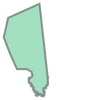

In [3]:
## Cities

cities = [
    # "New Delhi",
    "Jakarta"
]
gdf = ox.geocode_to_gdf(cities)

gdf.geometry.iloc[0]

In [4]:
geo_centroid = [gdf.geometry.centroid.x.iloc[0], gdf.geometry.centroid.y.iloc[0]]

boundary_coords = np.array(gdf.geometry.iloc[0].exterior.coords)

/jobfs/140911530.gadi-pbs/ipykernel_2303427/648222507.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_centroid = [gdf.geometry.centroid.x.iloc[0], gdf.geometry.centroid.y.iloc[0]]


In [5]:
## making circle around city

distances = np.sqrt((geo_centroid[0] - boundary_coords[:, 0])**2 + (geo_centroid[1] - boundary_coords[:, 1])**2)
radius = distances.max()
theta = np.linspace(0, 2 * np.pi, 150)

x = radius * np.cos(theta) + geo_centroid[0]
y = radius * np.sin(theta) + geo_centroid[1]

In [22]:
ds_ts_clip = ds_ts.where((ds_ts.lon > boundary_coords[:, 0].min()-0.5) & (ds_ts.lon < boundary_coords[:, 0].max()+0.5) \
                       & (ds_ts.lat > boundary_coords[:, 1].min()-0.5) & (ds_ts.lat < boundary_coords[:, 1].max()+0.5), drop=True )

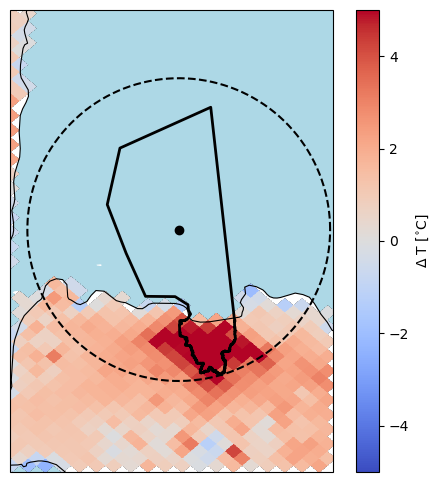

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([boundary_coords[:, 0].min()-0.5, boundary_coords[:, 0].max()+0.5,
               boundary_coords[:, 1].min()-0.5, boundary_coords[:, 1].max()+0.5], crs=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)
ax.add_feature(cf.OCEAN, facecolor='lightblue')

# egh.healpix_show(ds_ts_clip.isel(time=0), cmap='jet')
# artist = egh.healpix_show((ds_ts_clip-273.15).mean('time'), cmap='coolwarm', vmin=23, vmax=31)
artist = egh.healpix_show((ds_um_.ts - ds_icon_.ts), cmap='coolwarm', vmin=-5, vmax=5)
# fig.colorbar(artist, label=r"Land Surface Temperature [$^{\circ}$C]", orientation="vertical", pad=0.05)
fig.colorbar(artist, label=r"$\Delta$ T [$^{\circ}$C]", orientation="vertical", pad=0.05)

city_boundary = ShapelyFeature(gdf["geometry"][0], ccrs.PlateCarree(), edgecolor='k',
                               facecolor='none', linestyle='-', linewidth=2)
ax.add_feature(city_boundary)

ax.plot(geo_centroid[0], geo_centroid[1], marker='o', c='k')
ax.plot(x, y, '--', c='k')

# plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/ts_mean_um_jkt.png', bbox_inches='tight', dpi=200, )
# plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/ts_mean_icon_jkt.png', bbox_inches='tight', dpi=200, )
# plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/ts_mean_diff_um_icon_jkt.png', bbox_inches='tight', dpi=200, )

In [9]:
### masking city data

from shapely.geometry import Point, Polygon, MultiPolygon

lat = ds_ts_clip.lat
lon = ds_ts_clip.lon

cell_points = gpd.GeoSeries([Point(lon[i].item(), lat[i].item()) for i in range(len(lat))], crs="EPSG:4326")

### circular region:
circle_polygon = Polygon([ (radius * np.cos(angle) + geo_centroid[0],
                            radius * np.sin(angle) + geo_centroid[1] )
                            for angle in np.linspace(0, 2 * np.pi, 150)]) 

region_mask = cell_points.within(circle_polygon)
cell_mask_region = xr.DataArray(region_mask.values, dims=["cell"])

### city:
city_polygon = Polygon([ (boundary_coords[i, 0], boundary_coords[i, 1]) for i in range(boundary_coords.shape[0])])

city_mask = cell_points.within(city_polygon)
cell_mask_city = xr.DataArray(city_mask.values, dims=["cell"])



ts_region = ds_ts_clip.where(cell_mask_region)  # masking cicular region

ts_city = ts_region.where(cell_mask_city)  # masking city
ts_outside = ts_region.where(~cell_mask_city)  # masking outside city

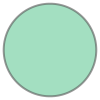

In [106]:
circle_polygon

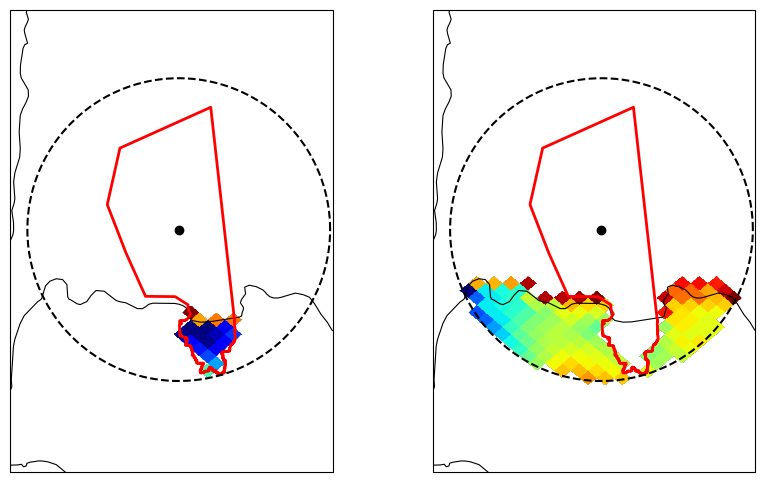

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

city_boundary = ShapelyFeature(gdf["geometry"][0], ccrs.PlateCarree(), edgecolor='r',
                               facecolor='none', linestyle='-', linewidth=2)

for ax_ in ax.flatten():
    ax_.set_extent([boundary_coords[:, 0].min()-0.5, boundary_coords[:, 0].max()+0.5,
                   boundary_coords[:, 1].min()-0.5, boundary_coords[:, 1].max()+0.5], crs=ccrs.PlateCarree())
    ax_.add_feature(cf.COASTLINE, linewidth=0.8)
    ax_.add_feature(cf.BORDERS, linewidth=0.4)
    ax_.add_feature(cf.OCEAN, facecolor='lightblue')
    
    ax_.add_feature(city_boundary)
    
    ax_.plot(geo_centroid[0], geo_centroid[1], marker='o', c='k')
    ax_.plot(x, y, '--', c='k')

egh.healpix_show(ts_city.isel(time=0), ax=ax[0], cmap='jet')

egh.healpix_show(ts_outside.isel(time=0), ax=ax[1], cmap='jet')

In [10]:
%%time

urban = ts_city.mean('cell').load()
rural = ts_outside.mean('cell').load()

CPU times: user 1min 4s, sys: 28.7 s, total: 1min 33s
Wall time: 2min 49s


In [16]:
dT = urban - rural

In [11]:
data_ = xr.merge([urban.rename('Tu'), rural.rename('Tr')])
# data_.to_netcdf('/g/data/hh5/tmp/ab2462/heckathon2025/Ts_um_jakarta.nc')
data_.to_netcdf('/g/data/hh5/tmp/ab2462/heckathon2025/Ts_icon_jakarta.nc')

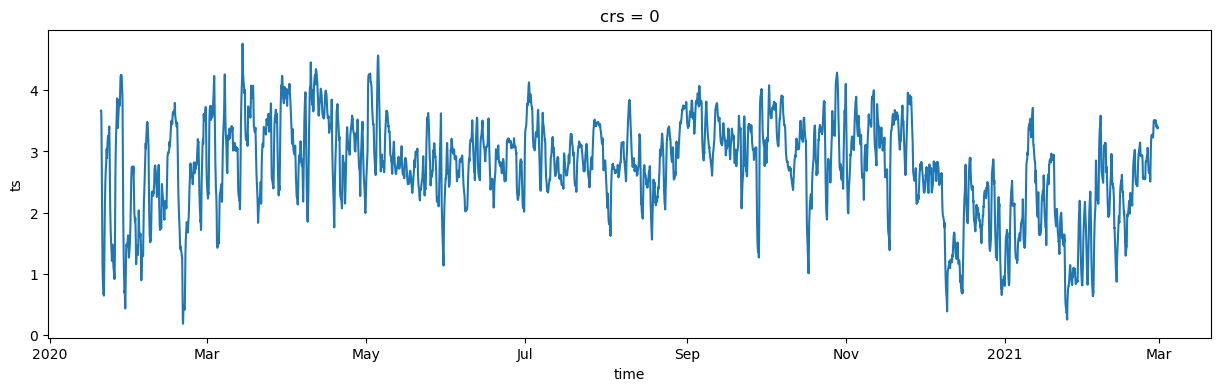

In [15]:
dT.rolling(time=24, center=True).mean().plot(figsize=(15,4))

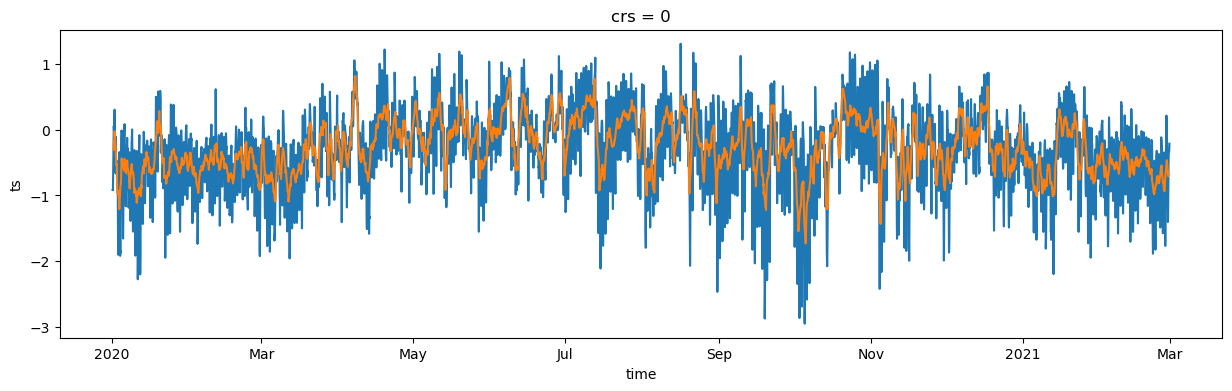

In [19]:
dT.rolling(time=6, center=True).mean().plot(figsize=(15,4))
dT.rolling(time=24, center=True).mean().plot()

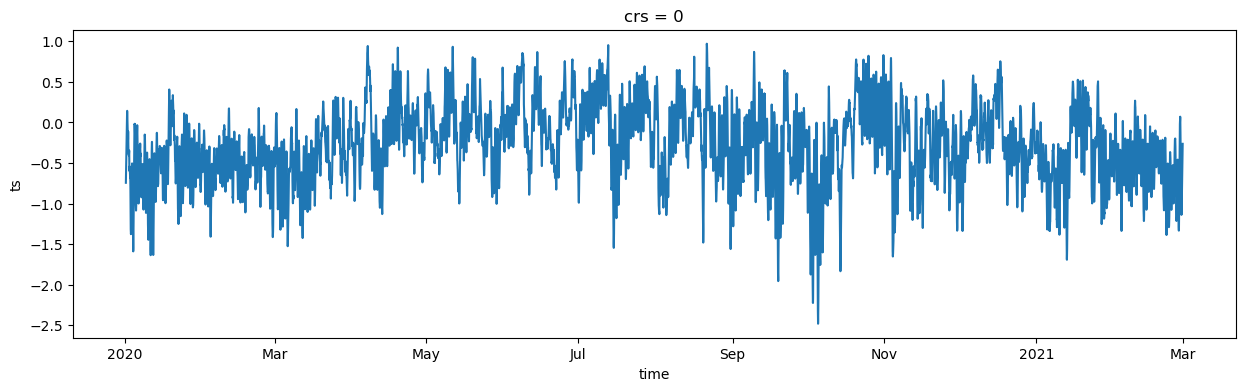

In [20]:
dT.rolling(time=12, center=True).mean().plot(figsize=(15,4))

In [12]:
da_um = xr.open_dataset('/g/data/hh5/tmp/ab2462/heckathon2025/Ts_um_jakarta.nc')
da_ic = xr.open_dataset('/g/data/hh5/tmp/ab2462/heckathon2025/Ts_icon_jakarta.nc')

In [13]:
dT_um = (da_um.Tu - da_um.Tr)
dT_ic = (da_ic.Tu - da_ic.Tr)

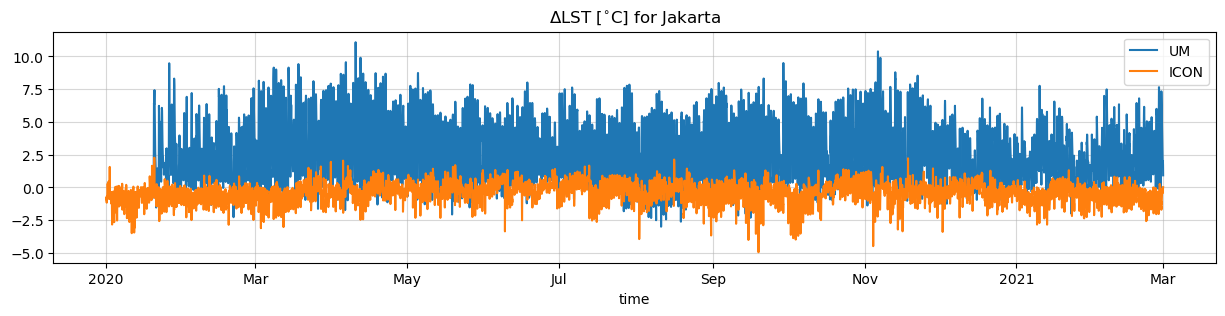

In [28]:
fig, ax = plt.subplots(1,1, figsize=(15,3))
dT_um.plot(label='UM')
dT_ic.plot(label='ICON')

ax.grid(alpha=0.5)

ax.legend()
ax.set(title=r'$\Delta$LST [$^{\circ}$C] for Jakarta', ylabel=r'')
# plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/LST_jkt.png', bbox_inches='tight', dpi=200, )

[Text(0.5, 1.0, '$\\Delta$LST [$^{\\circ}$C] for Jakarta'), Text(0, 0.5, '')]

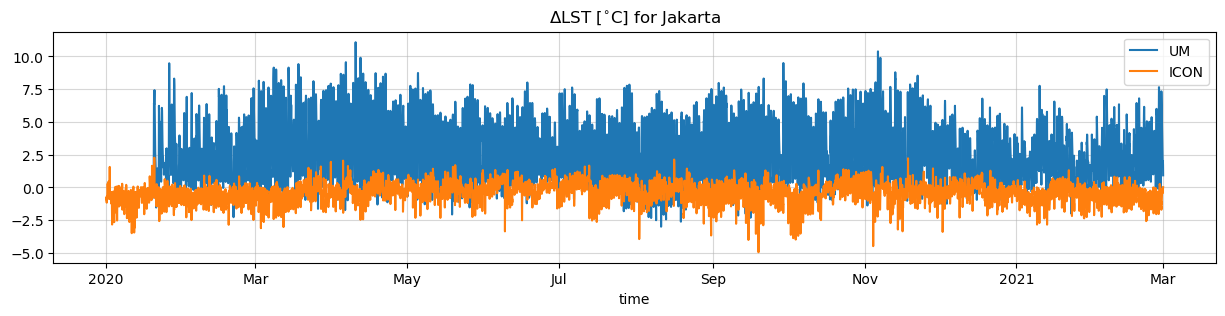

In [14]:
fig, ax = plt.subplots(1,1, figsize=(15,3))
dT_um.plot(label='UM')
dT_ic.plot(label='ICON')

ax.grid(alpha=0.5)

ax.legend()
ax.set(title=r'$\Delta$LST [$^{\circ}$C] for Jakarta', ylabel=r'')
# plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/LST_jkt.png', bbox_inches='tight', dpi=200, )